In [238]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
from model import RFCXModel
from utils import CFG
from data import RFCXDataset
from utils import id2path, path2id
import joblib
import cv2

In [243]:
tmp = cv2.imread('cams/s0/e0/00d442df7_-3.7666.jpg')

In [261]:
img, cam = joblib.load('tmp.jl')

In [262]:
img

array([[0.17445002, 0.220291  , 0.28820747, ..., 0.22253461, 0.25820464,
        0.31195208],
       [0.17445002, 0.220291  , 0.28820747, ..., 0.22253461, 0.25820464,
        0.31195208],
       [0.19544978, 0.22075325, 0.26966503, ..., 0.17152986, 0.24768345,
        0.30119523],
       ...,
       [0.14928995, 0.09121099, 0.10040016, ..., 0.13131435, 0.14914867,
        0.12753321],
       [0.12547123, 0.07793216, 0.08846813, ..., 0.1340971 , 0.13800615,
        0.10970582],
       [0.12547123, 0.07793216, 0.08846813, ..., 0.1340971 , 0.13800615,
        0.10970582]], dtype=float32)

In [272]:
cv2.imwrite('tmp.jpg', res)

True

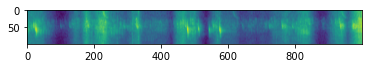

In [271]:
res = ((img*0.5+cam*0.5)*255).astype(int).clip(0, 255)
plt.imshow(res)

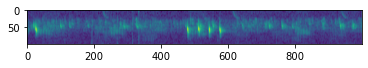

In [263]:
plt.imshow(img)

In [254]:
tmp[0]

array([[-39.282646, -35.06842 , -36.35589 , ..., -39.933544, -37.128902,
        -41.862568],
       [-39.56511 , -35.814682, -34.8508  , ..., -40.917526, -38.349262,
        -42.662506],
       [-37.82005 , -36.807835, -33.219006, ..., -43.350365, -41.782345,
        -44.60301 ],
       ...,
       [-34.088978, -35.407097, -33.850754, ..., -41.62722 , -39.046894,
        -41.747856],
       [-32.01038 , -33.804783, -30.433874, ..., -42.162136, -39.40376 ,
        -42.913498],
       [-31.150703, -33.408134, -29.344042, ..., -42.775997, -39.950783,
        -43.274406]], dtype=float32)

In [256]:
norm

(59, 1)

In [252]:
normalize(tmp[0]).min()

0.0

In [248]:
tmp[1]

array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ...,
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]], dtype=float32)

In [244]:
tmp

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [161]:
state_dict = torch.load('../../model/v3/s6/best.pth', map_location='cpu')
model = RFCXModel(CFG(state_dict['cfg']))
model.load_state_dict(state_dict['model'])
model = model.eval()

In [162]:
# Get the features from a model
class SaveFeatures():
    features = None
    def __init__(self, module): 
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): 
        self.features = output.data.numpy()

    def remove(self): 
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
#     cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = weight_fc.dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [163]:
class cfg:
    default_label = 0.
    sr = 48000
    aug = 0.
    data_dir = '../../input/kaggle'
    fold = 0
    use_fp = 1
    win_seconds = 10
    min_overlap_ratio = 0.5

mode = 'valid'
folds = joblib.load('folds.jl')
fnames = np.concatenate(folds[cfg.fold])
paths = [id2path(fname, cfg.data_dir, 'flac') for fname in fnames]
dataset = RFCXDataset(cfg, mode)

In [164]:
true = torch.stack([dataset[i]['labels'] for i in range(50)]).argmax(dim=1)
true

tensor([ 0, 18,  7,  0,  0, 11, 13, 16,  0, 10,  0,  8,  1, 23,  1,  2, 18, 11,
         1,  7,  0,  0,  0,  0,  1, 14, 20, 16, 16,  0,  0,  0,  0,  0,  8,  5,
        14,  0,  0,  0, 22, 10,  6, 15, 15,  6, 22, 11, 23,  0])

In [165]:
pred = model(torch.stack([dataset[i]['audio'] for i in range(50)], dim=0))[:, 0]
pred

tensor([-4.9986, -4.9376, -5.8545, -5.9224, -5.3622, -5.8734, -4.0805, -5.7889,
        -5.8335, -4.2082, -4.4848, -6.0898, -5.9579, -5.2162, -5.4418, -4.8796,
        -5.7079, -4.0623, -5.0769, -5.6563, -5.9580, -5.7894, -5.6486, -5.7108,
        -5.2779, -6.1996, -5.1981, -5.7175, -5.0162, -4.5111, -4.5526, -5.6971,
        -5.7943, -4.7378, -5.0641, -5.6743, -4.9862, -4.9515, -4.8917, -4.7827,
        -5.4386, -5.6094,  2.5843, -5.5234, -5.4178,  2.8997, -5.7429, -4.4930,
        -5.6681, -5.9150], grad_fn=<SelectBackward>)

In [166]:
from sklearn.metrics import roc_auc_score
roc_auc_score((true==6).detach().numpy().astype(int), pred.detach().numpy())

1.0

In [168]:
TARGET = 6

In [169]:
idx = np.argwhere(dataset.df['species_id'].values==TARGET).flatten()
len(idx)

60

In [218]:
nth = 6

In [220]:
cur = dataset[idx[nth]]
cur

{'labels': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
 'masks': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
 'audio': tensor([ 0.0003,  0.0063,  0.0003,  ..., -0.0048, -0.0089, -0.0027])}

In [221]:
sample = dataset.df.iloc[idx[nth]]
sample

species_id            6
songtype_id           1
t_min            42.560
f_min           562.500
t_max            44.704
f_max          4406.250
is_tp              True
Name: 8ee219910, dtype: object

In [222]:
x_img = cur['audio'].unsqueeze(0)

In [223]:
# Get features from last conv layer
final_layer = model.encoder.act2
activated_features = SaveFeatures(final_layer)

# Inference
_ = model.eval()
prediction = model(x_img)
pred_probabilities = prediction.squeeze()
activated_features.remove()
print('Top-1 prediction:', torch.topk(pred_probabilities, 1))

# Take weights from the first linear layer
weight_softmax_params = list(model.encoder.classifier.parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

# Get the top-1 prediction and get CAM
class_idx = torch.topk(pred_probabilities, 1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

Top-1 prediction: torch.return_types.topk(
values=tensor(2.3987, grad_fn=<TopkBackward>),
indices=tensor(0))


In [224]:
image = model.spectrogram_extractor(x_img)
image = model.logmel_extractor(image)
image = skimage.transform.resize(image[0, 0], (1024, 128))
cam_img = skimage.transform.resize(overlay[0], (1024, 128))

In [225]:
from utils import tomelscale
import matplotlib.patches as patches


In [230]:
image.shape

(1024, 128)

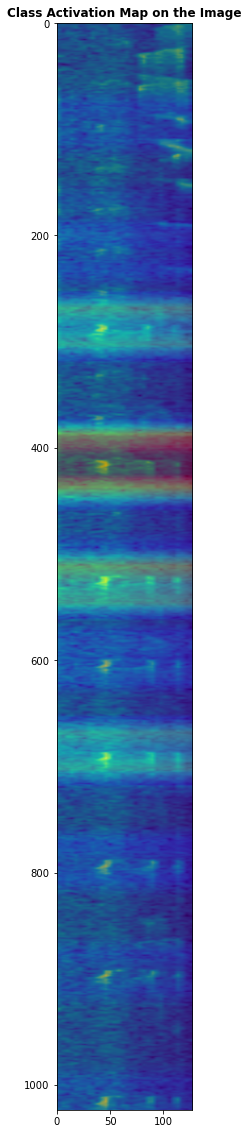

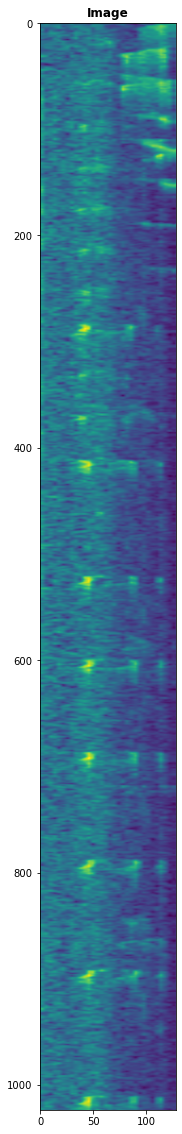

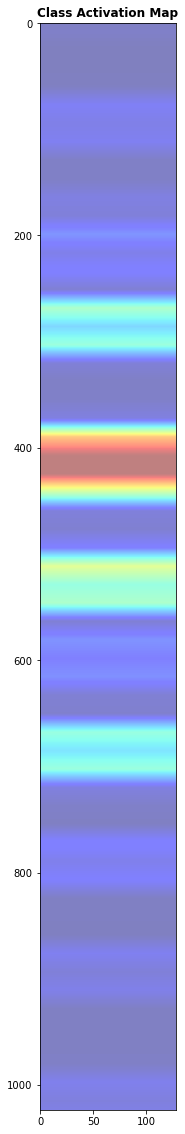

In [226]:

# Show CAM on the image
plt.figure(figsize=(10, 20))
plt.title('Class Activation Map on the Image', fontweight='bold')
plt.imshow(image)
plt.imshow(cam_img, alpha=0.3, cmap='jet')
plt.show()

fig, ax = plt.subplots(figsize=(10,20))
plt.title('Image', fontweight='bold')
# sid, fmin, fmax, tmin, tmax, istp = (
#             sample["species_id"], sample["f_min"], sample["f_max"], sample["t_min"], sample["t_max"], sample["is_tp"])
# fmin, fmax = tomelscale(fmin), tomelscale(fmax)
# ec = '#00ff00' if istp == 1 else '#0000ff'
# ax.add_patch(
#     patches.Rectangle(xy=(tmin, fmin), width=tmax-tmin, height=fmax-fmin, ec=ec, fill=False)
# )
plt.imshow(image)

# Show CAM
plt.figure(figsize=(10, 20))
plt.title('Class Activation Map', fontweight='bold')
plt.imshow(cam_img, alpha=0.5, cmap='jet')


